In [1]:
import pandas as pd
import numpy as np
import os, sys

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [36]:
from torch.utils.data.dataset import random_split

In [4]:
from time import sleep

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [6]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
DATA_PATH = '../data/ml-latest-small'

In [8]:
links_df = pd.read_csv(os.path.join(DATA_PATH, 'links.csv'))

In [9]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Web scraping

In [9]:
import requests
from bs4 import BeautifulSoup
from threading import Thread

In [7]:
%%timeit 
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
for i in l_w:
    string = string.replace(i, ' ')

457 ns ± 5.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [170]:
string = 'The quick brown fox jusmps over the lazy dog'
l_w = ['brown', 'jusmps']
s1 = string.replace('brown', '').replace('jusmps', '')

In [8]:
import re

In [171]:
string = 'The quick brown fox jusmps over the lazy dog'
prohibitedWords = ['brown', 'jusmps']
big_regex = re.compile('|'.join(map(re.escape, prohibitedWords)))
s2 = big_regex.sub("", string)

In [9]:
prohibitedWords = ['\n', '  ']

In [10]:
class QuoteGetter(Thread):
    def __init__(self, id):
        super().__init__()
        self.id = id
        
    def run(self):
        base = 'https://www.imdb.com/title/tt0{}/'
        r = requests.get(base.format(self.id))
        soup = BeautifulSoup(r.content, "lxml")
        try:
            self.quote = (re
                          .compile('|'.join(map(re.escape, prohibitedWords)))
                          .sub("", soup
                               .find('div', {'class': "summary_text"})
                               .get_text())
                         )
        except:
            self.quote = ''

In [11]:
def get_quotes(ids):
    threads = [QuoteGetter(i) for i in ids]
    for thread in threads:
        sleep(0.1)
        thread.start()
    for thread in threads:
        sleep(0.1)
        thread.join()
    quotes = dict(zip(ids, [thread.quote for thread in threads]))
    return quotes

In [15]:
ids = list(links_df.imdbId[:1000])

In [16]:
%time description = get_quotes(ids)

Wall time: 3min 27s


In [17]:
import json

# as requested in comment
exDict = {'Description': description}

with open('../data/description.txt', 'w') as file:
     file.write(json.dumps(exDict)) 

In [584]:
def id2descripion(id):
    r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
    page = BeautifulSoup(r.content, "html.parser")
    # short desscription
    ##text = page.find('div', {'class': "summary_text"}).text
    # StoryLine
    text = page.find('div', {'class': "inline canwrap"}).text
    return text

In [61]:
%%timeit
id = 113041
id2descripion(id)

664 ms ± 56.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
r = requests.get('https://www.imdb.com/title/tt0{}/'.format(id))
page = str(r.content)

In [81]:
page.find('div class="inline canwrap"')

#### Scrap image

In [6]:
from PIL import Image
from io import BytesIO

In [24]:
class QuoteImage(Thread):
    def __init__(self, id):
        super().__init__()
        self.id = id
        
    def run(self):
        base = 'https://www.imdb.com/title/tt0{}/'
        r = requests.get(base.format(self.id))
        soup = BeautifulSoup(r.content, "lxml")
        try:
            url = (soup
                          .find('div', 
                                attrs={'class': "poster"})
                          .find('img')['src'])
            response = requests.get(url)
            self.quote = Image.open(BytesIO(response.content))
        except:
            self.quote = ''

In [25]:
def get_Image(ids):
    threads = [QuoteImage(i) for i in ids]
    for thread in threads:
        thread.start()
    for thread in threads:
        thread.join()
    quotes = dict(zip(ids, [thread.quote for thread in threads]))
    return quotes

In [43]:
ids = list(links_df.imdbId[:1000])
img = get_Image(ids)

## Recommender collaborative filtering

In [10]:
movies_df = pd.read_csv(os.path.join(DATA_PATH, 'movies.csv'))

In [11]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 4").drop(columns=['rating', 'timestamp'])

In [408]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 20]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 20]).index)
ratings_df.query("movieId in @m_id & userId in @u_id", inplace=True)

In [409]:
id2id = {e: i for i, e in enumerate(ratings_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [410]:
list_movies = ratings_df.groupby('userId').agg(list).movieId

In [34]:
def to_onehot(labels, n_categories, dtype=torch.float32):
    batch_size = len(labels)
    one_hot_labels = torch.zeros(size=(batch_size, n_categories), dtype=dtype)
    for i, label in enumerate(labels):
        # Subtract 1 from each LongTensor because your
        # indexing starts at 1 and tensor indexing starts at 0
        label = torch.LongTensor(label)
        one_hot_labels[i] = one_hot_labels[i].scatter_(dim=0, index=label, value=1.)
    return one_hot_labels

In [412]:
n_user = ratings_df.userId.max() + 1
user_oh = to_onehot([[u] for u in ratings_df.userId], n_user, dtype=torch.float32)

In [413]:
n_movie = ratings_df.movieId.max() + 1
movie_oh = to_onehot([[m] for m in ratings_df.movieId], n_movie, dtype=torch.float32)

In [414]:
n_movie = ratings_df.movieId.max() + 1
output_oh = to_onehot([list_movies[u] for u in ratings_df.userId], n_movie, dtype=torch.float32)

In [79]:
class ratingsDataset(Dataset):
    
    def __init__(self, data, itemId, userId):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        #self.itemInput, self.userInput = (to_onehot([[i] for i in self.itemId], self.itemId.max() + 1, dtype=torch.float32), 
        #                                  to_onehot([[u] for u in self.userId], self.userId.max() + 1, dtype=torch.float32))
        list_item = data.groupby(userId).agg(list)[itemId]
        self.output = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        
    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.output[idx])

In [81]:
split = 0.6

In [94]:
dataset = ratingsDataset(ratings_df, 'movieId', 'userId')
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [12]:
class Reco(nn.Module):
    
    def __init__(self, nItem, nUser):
        super(Reco, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)
        self.nnItem = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFinal = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        # total
        self.affine_output = nn.Linear(in_features=10+10, out_features=nItem)
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFinal(x_mlp)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf), dim=1)
        x = self.affine_output(vector)
        # x = self.logistic(logits)   
        return x

In [546]:
R = Reco(ratings_df.movieId.max() + 1, ratings_df.userId.max() + 1 )

In [106]:
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(R.parameters(), lr=0.001, betas=(0.5, 0.9))

In [115]:
all_losses = []
batches = 0

In [113]:
start = time.time()

for epoch in range(25):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, targets = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = R(items, users)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 0 0.2120
0m 1s, 0 500 0.2237
0m 3s, 1 0 0.2491
0m 4s, 1 500 0.2126
0m 6s, 2 0 0.2408
0m 8s, 2 500 0.2053
0m 9s, 3 0 0.1936
0m 11s, 3 500 0.2430
0m 13s, 4 0 0.2449
0m 14s, 4 500 0.2013
0m 16s, 5 0 0.2637
0m 18s, 5 500 0.1737
0m 20s, 6 0 0.2603
0m 21s, 6 500 0.2370
0m 23s, 7 0 0.1926
0m 25s, 7 500 0.2272
0m 26s, 8 0 0.2575
0m 28s, 8 500 0.2236
0m 30s, 9 0 0.1765
0m 32s, 9 500 0.2006
0m 33s, 10 0 0.2419
0m 35s, 10 500 0.1759
0m 37s, 11 0 0.2294
0m 39s, 11 500 0.2066
0m 40s, 12 0 0.1659
0m 42s, 12 500 0.2277
0m 44s, 13 0 0.2165
0m 46s, 13 500 0.1464
0m 47s, 14 0 0.1695
0m 49s, 14 500 0.1800
0m 51s, 15 0 0.1760
0m 53s, 15 500 0.1918
0m 55s, 16 0 0.2066
0m 57s, 16 500 0.2001
0m 59s, 17 0 0.2174
1m 0s, 17 500 0.2056
1m 2s, 18 0 0.1965
1m 5s, 18 500 0.2133
1m 6s, 19 0 0.1531
1m 8s, 19 500 0.1858
1m 10s, 20 0 0.1762
1m 12s, 20 500 0.2203
1m 14s, 21 0 0.1825
1m 15s, 21 500 0.2131
1m 17s, 22 0 0.1728
1m 19s, 22 500 0.1290
1m 20s, 23 0 0.1541
1m 22s, 23 500 0.1796
1m 24s, 24 0 0.1385
1m 2

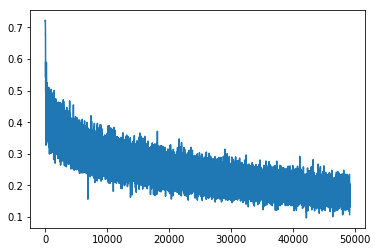

In [114]:
plt.figure()
plt.plot(all_losses)

In [117]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        keep_one = targets == 1
        total += 1
        correct += sum(predicted[keep_one] == targets[keep_one]).item() / targets[targets == 1].size(0)
        # total += targets.size(0)
        # correct += (predicted == targets).sum(dim=0).float()

print((correct / total))

0.08145822920212702


In [118]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        items, users, targets = data
        outputs = R(items, users)
        predicted = torch.round(outputs.data)
        total += targets.size(0)
        correct += (predicted == targets).sum(dim=0).float()

<BarContainer object of 575 artists>

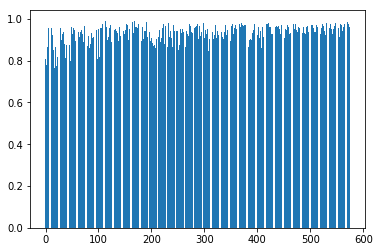

In [119]:
plt.bar(np.arange(ratings_df.movieId.max() + 1), (correct / total).numpy())

## Recommender description based

In [13]:
import json

with open('../data/description.txt') as json_file:
    description = json.load(json_file)['Description']

In [14]:
imdbId2mId = {i + 1: m for i, m in enumerate(links_df.imdbId)}

In [14]:
import itertools

In [15]:
l = [c.split('|') for c in list(movies_df.genres)]

In [16]:
%timeit a = [item for sublist in l for item in sublist]
%timeit b = list(itertools.chain.from_iterable(l))

738 µs ± 5.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
450 µs ± 6.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
import numpy as np
genres = list(np.unique(list(itertools.chain.from_iterable(l))))

In [18]:
genre_oh = np.array([[int(genres[i] in j) for i in range(20)] for j in movies_df.genres])

In [19]:
id = 18
description[str(imdbId2mId[id+1])], movies_df.title[id]

('Ace Ventura, Pet Detective, returns from a spiritual quest to investigate the disappearance of a rare white bat, the sacred animal of a tribe in Africa.',
 'Ace Ventura: When Nature Calls (1995)')

In [20]:
## rule to keep only some movies
a = ratings_df.movieId.value_counts()
b = set(a[a.between(5, 50)].index)
c = ratings_df.query("movieId in @b")

In [421]:
r_df = pd.DataFrame({
    'movieId': [movies_df.movieId[i] for i in range(1000)], 
    'title': [movies_df.title[i] for i in range(1000)],
    'description': [description[str(imdbId2mId[i+1])] for i in range(1000)]
})

In [422]:
contentMovie_df = pd.merge(r_df, pd.DataFrame(genre_oh, columns=genres), right_index=True, left_index=True)

In [423]:
contentMovie_df.query("description != ''", inplace=True)

In [16]:
DATA_FOLDER = '../data'
FILE = 'train.csv'

In [425]:
contentMovie_df.drop(columns='title', inplace=True)
contentMovie_df.to_csv(os.path.join(DATA_FOLDER, FILE), index=False)

In [17]:
contentMovie_df = pd.read_csv(os.path.join(DATA_FOLDER, FILE))

In [28]:
from gensim.models import Word2Vec
import torch.nn.functional as F
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_sw = spacy.lang.en.stop_words.STOP_WORDS

def fct(doc):
    return ' '.join([w.lemma_ for w in doc 
            if w.lemma_ not in spacy_sw and 
            not w.is_punct and 
            w.tag_ != 'VBN'
           ])


def create_weight(text):
    desc = list(text)
    desc = [d 
            if type(d) is not np.float 
            else 'Nothing' 
            for d in desc]
    docs = nlp.pipe(desc)
    split_d = [fct(doc).split() for doc in docs]
    model_emb_w = Word2Vec(split_d, min_count=10, size=64)
    weights = torch.FloatTensor(model_emb_w.wv.vectors)
    weights = torch.cat((weights, weights.mean(0, keepdim=True)), dim=0)
    return weights, model_emb_w, split_d

In [470]:
weigths = create_weight(contentMovie_df.description)

In [36]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)
# padding the input (put this in dataloader)
word2id_pad = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)

In [39]:
genreTensor = torch.Tensor(np.array(contentMovie_df.drop(columns=['description'])))

In [40]:
class ClassifierDataset(Dataset):
    
    def __init__(self, data, word2id):
        
        self.movie_description = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)
        self.n = word2id_pad.shape[0]
        self.output = torch.Tensor(np.array(data.drop(columns=['description', 'movieId'])))
        
    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.movie_description[idx],self.output[idx])

In [41]:
split = 0.7

In [239]:
dataset = ClassifierDataset(contentMovie_df, word2id_pad)
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [289]:
class PredictGenre(nn.Module):
    def __init__(self, weights, n_cat):
        super(PredictGenre, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(weights)
        # self.lstm = nn.LSTM(input_size = 64,
        #                     hidden_size = 32,
        #                     num_layers = 1)
        self.fc1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, n_cat), 
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        # x, _ = self.lstm(x)
        x = x.mean(dim=1)
        x = self.fc1(x)
        return x

In [384]:
g = PredictGenre(weights, 1)

In [386]:
neg = -(dataset.output - 1).sum(dim=0)
pos = dataset.output.sum(dim=0)
pos[pos == 0] = 10

In [387]:
pos_weight = (neg/pos) * 10

In [388]:
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight[1])
optimizer = optim.Adam(g.parameters())

In [389]:
all_losses = []
batches = 0

In [395]:
o[:, 1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

In [402]:
start = time.time()
for epoch in range(25):
    for i, data in enumerate(train_loader):
        d, o = data
        
        b = o.size(0)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = g(d)
        loss = criterion(outputs.view(1, b), o[:, 1].view(1, b))
        optimizer.step()
        loss.backward()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss)
        batches += 1

print('Finished Training')

0m 0s, 0 16 5.9037
0m 0s, 1 25 2.7320
0m 0s, 2 34 3.7892
0m 0s, 3 43 5.5512
0m 0s, 4 52 4.8463
0m 0s, 5 61 5.1987
0m 0s, 6 70 5.5513
0m 0s, 7 79 3.4367
0m 0s, 8 88 4.1416
0m 0s, 9 97 4.4940
0m 0s, 10 106 3.7892
0m 0s, 11 115 5.5513
0m 0s, 12 124 4.4940
0m 0s, 13 133 4.1416
0m 0s, 14 142 4.4940
0m 0s, 15 151 3.0844
0m 0s, 16 160 4.1416
0m 0s, 17 169 3.0844
0m 0s, 18 178 4.4939
0m 0s, 19 187 5.1988
0m 0s, 20 196 4.1416
0m 0s, 21 205 5.9036
0m 0s, 22 214 4.4941
0m 0s, 23 223 5.9037
0m 0s, 24 232 6.2559
Finished Training


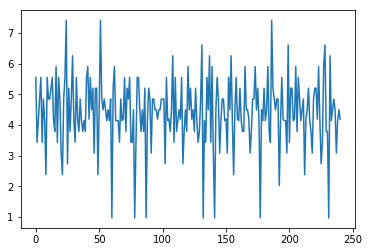

In [403]:
plt.plot(all_losses)

In [407]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        d, o = data
        outputs = g(d)
        predicted = torch.round(outputs.data)
        keep_one = o == 1
        total += 1
        correct += sum(predicted[keep_one] == o[keep_one]).item() / o[keep_one].size(0)
        # total += o.size(0)
        # correct += (predicted == o).sum(dim=0).float()
        # print((predicted[keep_one] == o[keep_one]))

print((correct / total))

RuntimeError: The shape of the mask [64, 20] at index 1 does not match the shape of the indexed tensor [64, 1] at index 1

### Reco txt + interaction

In [20]:
text_df = contentMovie_df.iloc[:,:2]

In [21]:
id_desc = set(text_df.movieId)

In [22]:
ratings_df = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv')).query("rating >= 3 and movieId in @id_desc").drop(columns=['rating', 'timestamp'])

In [23]:
m_id = set((ratings_df.movieId.value_counts()[ratings_df.movieId.value_counts() > 5]).index)
u_id = set((ratings_df.userId.value_counts()[ratings_df.userId.value_counts() > 5]).index)
ratings_df.query("movieId in @m_id & userId in @u_id", inplace=True)

In [24]:
id2id = {e: i for i, e in enumerate(text_df.movieId.unique())}
ratings_df['movieId'] = ratings_df.movieId.map(id2id)

In [29]:
weights, model, split_d = create_weight(text_df.description)

In [30]:
vocab = list(model.wv.vocab)

In [31]:
word2id = [torch.LongTensor([vocab.index(w) for w in s if w in vocab]) for s in split_d]
# the final term is for padding
pad_int = len(vocab)

In [32]:
class RecoDataset(Dataset):
    def __init__(self, data, itemId, userId, word2id):
        
        self.itemId, self.userId = torch.LongTensor(data[itemId]), torch.LongTensor(data[userId])
        self.n_user, self.n_item = len(self.userId.unique()), len(self.itemId.unique())
        self.n = len(self.itemId)
        list_item = data.groupby(userId).agg(list)[itemId]
        self.output = to_onehot([list_item[u.item()] for u in self.userId], self.itemId.max() + 1, dtype=torch.float32)
        
        desc_id = torch.nn.utils.rnn.pad_sequence(word2id, padding_value=pad_int, batch_first=True)
        self.movie_description = desc_id[self.itemId]

    def __len__(self):
        return self.n
        
    def __getitem__(self, idx):
        return (self.itemId[idx], self.userId[idx], self.movie_description[idx], self.output[idx])

In [37]:
split= 0.75

In [38]:
dataset = RecoDataset(ratings_df, 'movieId', 'userId', word2id)
lengths = [int(dataset.__len__() * split), int(dataset.__len__() * (1-split)) + 1]
lengths = lengths if sum(lengths) == dataset.__len__() else [lengths[0], lengths[1] - 1]
train_data, test_data = random_split(dataset, lengths)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [39]:
class RecoWithText(nn.Module):
    
    def __init__(self, nItem, nUser):
        super(RecoWithText, self).__init__()

        ## GMF
        self.embedding_user_gmf = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_gmf = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)      
        ## MLP
        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=nUser, embedding_dim=10)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=nItem, embedding_dim=10)
        self.nnItem = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnUser = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.nnFusion = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        # total
        self.affine_output = nn.Linear(in_features=10+10+10, out_features=nItem)
        
        self.embedding = nn.Embedding.from_pretrained(weights)
        self.fc1 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        
        self.logistic = nn.Sigmoid()  
        
    def forward(self, item, user, d):
        # GMF
        user_embedding_gmf = self.embedding_user_gmf(user)
        item_embedding_gmf = self.embedding_item_gmf(item)        
        x_gmf = torch.mul(user_embedding_gmf, item_embedding_gmf)
        # MLP
        user_embedding_mlp = self.embedding_user_mlp(user)
        item_embedding_mlp = self.embedding_item_mlp(item)
        x1 = self.nnItem(item_embedding_mlp)
        x2 = self.nnUser(user_embedding_mlp)
        x_mlp = torch.cat((x1, x2), dim=1)
        x_mlp = self.nnFusion(x_mlp)     
        # text layer
        d = self.embedding(d)
        d = d.mean(dim=1)
        d = self.fc1(d)
        # concat the two models
        vector = torch.cat((x_mlp, x_gmf, d), dim=1)   
        x = self.affine_output(vector)
        
        # x = self.logistic(logits)   
        return x

In [65]:
R = RecoWithText(ratings_df.movieId.max()+1, ratings_df.userId.max()+1)

In [66]:
R1 = Reco(ratings_df.movieId.max()+1, ratings_df.userId.max()+1)

In [67]:
neg = -(dataset.output - 1).sum(dim=0)
pos = dataset.output.sum(dim=0)
pos[pos == 0] = 1

In [68]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight= neg / pos)
optimizer = optim.Adam(R.parameters(), lr=0.001, betas=(0.5, 0.9))

In [69]:
all_losses = []
batches = 0

In [76]:
start = time.time()

for epoch in range(5):  # loop over the dataset multiple times

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        items, users, d, targets = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # outputs = R1(items, users)#, d)
        outputs = R(items, users, d)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 500 == 0:
            print('%s, %d %d %.4f' % (timeSince(start), epoch, batches, loss))
        all_losses.append(loss.item())
        batches += 1

print('Finished Training')

0m 0s, 0 3590 0.3918
0m 1s, 0 4090 0.3840
0m 2s, 1 4308 0.4289
0m 5s, 1 4808 0.3687
0m 6s, 2 5026 0.3262
0m 8s, 2 5526 0.3227
0m 9s, 3 5744 0.3708
0m 12s, 3 6244 0.4076
0m 13s, 4 6462 0.3877
0m 15s, 4 6962 0.2786
Finished Training


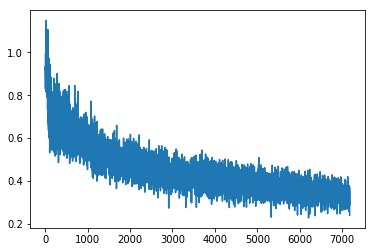

In [77]:
plt.figure()
plt.plot(all_losses)

In [78]:
correct = 0
correct0 = 0
correct1 = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        items, users, d, targets = data
        outputs = R(items, users, d)
        total += targets.size(0)
        correct += criterion(outputs, targets).item()
        correct1 += (sum(targets[targets == 1] == torch.round(a(outputs))[targets == 1]) / sum(targets[targets == 1])).item()


In [79]:
(correct / total, correct1 / total)

(0.02155981237968702, 0.00857397933681122)

### Recommender image based

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms


class Img2Vec():

    def __init__(self, cuda=False, model='resnet-101', layer='default', layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.  See more docs: https://github.com/christiansafka/img2vec.git
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        self.device = torch.device("cuda" if cuda else "cpu")
        self.layer_output_size = layer_output_size
        self.model_name = model
        
        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Scale((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(self.device)

        if self.model_name == 'alexnet':
            my_embedding = torch.zeros(1, self.layer_output_size)
        else:
            my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

        def copy_data(m, i, o):
            my_embedding.copy_(o.data)

        h = self.extraction_layer.register_forward_hook(copy_data)
        h_x = self.model(image)
        h.remove()

        if tensor:
            return my_embedding
        else:
            if self.model_name == 'alexnet':
                return my_embedding.numpy()[0, :]
            else:
                return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """
        if model_name == 'resnet-101':
            model = models.resnet101(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 2048
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [ ]:
img2vec = Img2Vec()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\micka/.torch\models\resnet101-5d3b4d8f.pth
1679360it [00:40, 36923.52it/s]

In [143]:
with_img = [id for id in ids if type(img[id]) is not str]

In [83]:
%%time
matrix_img = torch.cat([img2vec.get_vec(img[id], tensor=True) for id in ids if id in with_img], dim=0)

Wall time: 1min 33s


In [136]:
array_img = matrix_img.view(741, 512).numpy()

In [139]:
from sklearn.metrics.pairwise import cosine_similarity

In [142]:
sim = cosine_similarity(array_img)

Choose one image 83


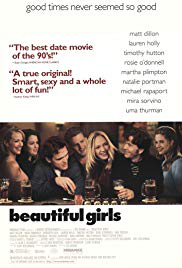

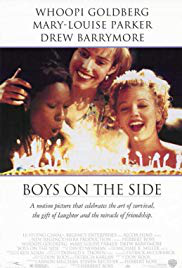

0.82190436


In [182]:
im = int(input('Choose one image'))
with_img[im]
display(img[with_img[im]])
display(img[with_img[np.argsort(-sim[im])[1]]])
print(-np.sort(-sim[im])[1])

In [32]:
import torch
import torchvision
from torchvision import transforms, models

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [34]:
for id in with_img:
    img[id].save('../data/image/'+str(id)+'.jpeg')

NameError: name 'with_img' is not defined

In [23]:
trainset = torchvision.datasets.ImageFolder('../data/traindata', transform=transform)

In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [28]:
feature_extract = True
model_ft = None

In [35]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}